In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
main_path=os.getcwd()
print(main_path)

C:\Users\METE\Desktop\tfod_steel\workspace\training_demo


In [24]:
image_paths = []
for image_name in os.listdir("C:\\Users\\METE\\Desktop\\img_annotation"):
    image_paths.append(os.path.join("C:\\Users\\METE\\Desktop\\img_annotation", image_name))
print(image_paths)

['C:\\Users\\METE\\Desktop\\img_annotation\\7.png']


In [25]:
MODEL_DATE = '20221206'
MODEL_NAME = 'my_resnet'
LABEL_FILENAME = 'label_map.pbtxt'
PATH_TO_LABELS = os.path.join(main_path, "annotations", LABEL_FILENAME)
PATH_TO_MODEL_DIR = os.path.join(main_path, "models")
PATH_TO_CFG = os.path.join(PATH_TO_MODEL_DIR, "my_resnet", "pipeline.config" )
PATH_TO_CKPT = os.path.join(PATH_TO_MODEL_DIR, "my_resnet")

In [26]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder


print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 0.25800061225891113 seconds


In [27]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [28]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

In [29]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

Running inference for C:\Users\METE\Desktop\img_annotation\7.png... Done


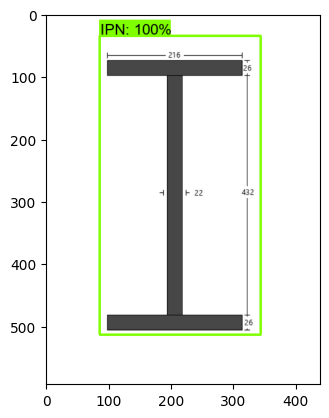

In [30]:
for image_path in image_paths:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)
    img_height, img_width = image_np.shape[0], image_np.shape[1]

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=0.3,
            agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

In [31]:
boxes = detections['detection_boxes']
# get all boxes from an array
max_boxes_to_draw = boxes.shape[0]
# get scores to get a threshold
scores = detections['detection_scores']
print(scores)
# this is set as a default but feel free to adjust it to your needs
min_score_thresh=.5
# iterate over all objects found
for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
        # boxes[i] is the box which will be drawn
        class_name = category_index[detections['detection_classes'][i+1]]['name']
        print ("This box is gonna get used", boxes[i], detections['detection_classes'][i+1])

[9.99875903e-01 2.78691333e-02 7.32026063e-03 4.80487543e-05
 4.00727622e-05 1.38293826e-05 1.30853095e-05 1.29642285e-05
 1.23533546e-05 1.20001714e-05 1.18489834e-05 1.17800755e-05
 1.15538160e-05 1.14815257e-05 1.09828879e-05 9.34388117e-06
 8.19811521e-06 8.12732924e-06 8.05817581e-06 8.01275382e-06
 7.66257017e-06 7.58265423e-06 6.47852676e-06 6.15030785e-06
 6.02872979e-06 5.50417280e-06 5.26766962e-06 5.13447367e-06
 4.93179550e-06 4.67257360e-06 4.35413995e-06 4.30737100e-06
 4.21178493e-06 4.14526994e-06 3.85908925e-06 3.84918985e-06
 3.71036595e-06 3.68388237e-06 3.64223638e-06 3.60323429e-06
 3.44346586e-06 3.44044588e-06 3.43851320e-06 3.43129000e-06
 3.40724682e-06 3.38794848e-06 3.33456796e-06 3.29074783e-06
 3.22772394e-06 3.19801484e-06 3.18249681e-06 3.16320848e-06
 3.16125693e-06 3.11603640e-06 3.00649708e-06 2.98799614e-06
 2.98253303e-06 2.97690485e-06 2.97071847e-06 2.86985346e-06
 2.83788972e-06 2.69079487e-06 2.65827407e-06 2.54675683e-06
 2.53569169e-06 2.409889

In [32]:
top_y = boxes[0][0]*img_height
left_x = boxes[0][1]*img_width
bottom_y = boxes[0][2]*img_height
right_x = boxes[0][3]*img_width
print(top_y, left_x, bottom_y, right_x)

35.78952323272824 85.76165533065796 513.921992123127 344.75510662794113


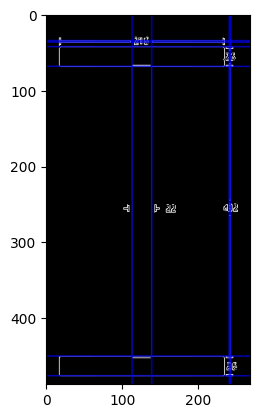

In [33]:
import cv2
import math
image_path = image_paths[0]
img = cv2.imread(image_path)
extra_pixels = 5
y_top = int(top_y)-extra_pixels
y_bottom = int(bottom_y)+extra_pixels
x_left = int(left_x) - extra_pixels
x_right = int(right_x) + extra_pixels
roi = img[y_top:y_bottom,x_left:x_right]

"""
roi_y = [int(top_y)-extra_pixels:int(bottom_y)+extra_pixels]
roi_x = [int(left_x)-extra_pixels:int(right_x)+extra_pixels]
roi = img[roi_y,roi_x]
"""


#Hough Line
dst = cv2.Canny(roi, 50, 200, None, 3)
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
lines = cv2.HoughLines(dst, 1, np.pi/180, 150, None, 0,0)
line_points = []
if lines is not None:
       for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            line_points.append([pt1, pt2])
            cv2.line(cdst, pt1, pt2, (0,0,255), 1, cv2.LINE_AA)
cv2.imwrite("roi.png", roi)
plt.imshow(cdst)


#Probabilistic Hough Line
# edges = cv2.Canny(roi, 50, 150, apertureSize=3)
# linesP = cv2.HoughLinesP(edges, 1, np.pi/180, 50, 100, 2)
# if linesP is not None:
#    for i in range(0, len(linesP)):
#        l = linesP[i][0]
#        cv2.line(roi, (l[0], l[1]), (l[2], l[3]), (255,0,0), 2, cv2.LINE_AA)
# plt.imshow(roi)

Looking for C:\Users\METE\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\METE\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 1s 1s/step
[('216', array([[115.,  30.],
       [138.,  30.],
       [138.,  42.],
       [115.,  42.]], dtype=float32)), ('26', array([[236.,  51.],
       [251.,  51.],
       [251.,  62.],
       [236.,  62.]], dtype=float32)), ('432', array([[234., 250.],
       [255., 250.],
       [255., 261.],
       [234., 261.]], dtype=float32)), ('f', array([[142., 251.],
       [152., 251.],
       [152., 262.],
       [142., 262.]], dtype=float32)), ('22', array([[157., 251.],
       [174., 251.],
       [174., 263.],
       [157., 263.]], dtype=float32)), ('26', array([[238., 459.],
       [253., 459.],
       [253., 470.],
       [238., 470.]], dtype=float32))]


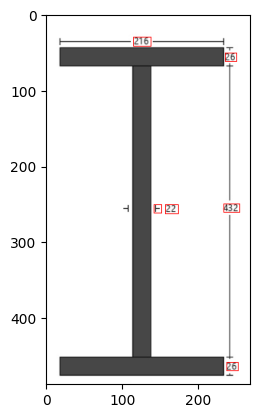

In [34]:
import keras_ocr
roi_path = os.path.join(main_path, "roi.png")
pipeline = keras_ocr.pipeline.Pipeline()
image = keras_ocr.tools.read(roi_path)
prediction = pipeline.recognize([image])[0]
print(prediction)
boxes = [value[1] for value in prediction]
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=boxes, color=(255, 0, 0), thickness=1)
plt.imshow(canvas)
plt.show()

In [39]:
annot_centers = []
readings = [value[0] for value in prediction]
value_center_list = []
for box in boxes:
    x_center = []
    y_center = []
    x_sum = 0
    y_sum = 0
    for point in box:
        x_sum += point[0]
        y_sum += point[1]
    x_center = int(x_sum/4)
    y_center = int(y_sum/4)
    value_center_list.append([x_center, y_center])
for i in range(len(value_center_list)):
    value_center_list[i].append(readings[i])
print(value_center_list)

[[126, 36, '216'], [243, 56, '26'], [244, 255, '432'], [147, 256, 'f'], [165, 257, '22'], [245, 464, '26']]


In [40]:
print(line_points)

[[(243, 1000), (243, -1000)], [(241, 1000), (241, -1000)], [(113, 1000), (113, -1000)], [(139, 1000), (139, -1000)], [(-1000, 42), (999, 43)], [(-1000, 476), (999, 477)], [(-1000, 68), (999, 69)], [(-1000, 450), (999, 451)], [(-1000, 34), (999, 35)], [(-1000, 36), (999, 37)]]


In [41]:
print(len(line_points))
print(roi.shape[0])

10
488


In [43]:
for center in value_center_list:
    try:
        center[2] = int(center[2])
    except:
        print(center[2], "is not an integer so it will be discarded")
        continue
    if roi.shape[1]*0.25 < center[0] < roi.shape[1] * 0.75:
        if roi.shape[0]*0.25 < center[1] < roi.shape[0] * 0.75:
            t_web = int(center[2])
        else:
            b_flange = int(center[2])
    else:
        if  center[0] > roi.shape[1]*0.25:
            top_t_flange = int(center[2])
        elif roi.shape[0]*0.75 > center[1]:
            bottom_t_flange = int(center[2])
        else:
            h_web = int(center[2])
            
print(t_web, b_flange, top_t_flange, bottom_t_flange, h_web)

f is not an integer so it will be discarded
22 216 26 26 432


In [45]:
# Moment of inertia calculations
total_shape_area = (t_web*h_web) + (top_t_flange * b_flange) + (bottom_t_flange * b_flange)
# Datum assumed as top left of the shape
# Strong axis will be taken as x axis, so week axis will be y axis
area_moments_x = (top_t_flange * b_flange) * (top_t_flange/2) + (t_web*h_web)*(h_web/2 + top_t_flange)+ (bottom_t_flange * b_flange) * (top_t_flange + h_web + bottom_t_flange/2)
center_of_gravity_x = area_moments_x / total_shape_area
area_moments_y = (top_t_flange * b_flange) * (b_flange/2) + (t_web*h_web)*(b_flange/2)+ (bottom_t_flange * b_flange) * (b_flange/2)
center_of_gravity_y = area_moments_y / total_shape_area
# These values are obvious for symmetrical shapes, but just for different cases these should be calculated
moment_of_inertia_x = (1/12) * b_flange * top_t_flange**3 + (top_t_flange * b_flange) * (center_of_gravity_x - top_t_flange/2)**2 + (1/12)* t_web * h_web**3 + (t_web * h_web) * (center_of_gravity_x - (top_t_flange + h_web/2))**2 + (1/12) * b_flange * bottom_t_flange**3 + (b_flange * bottom_t_flange) * ((top_t_flange + h_web + bottom_t_flange/2) - center_of_gravity_x)**2
print(moment_of_inertia_x)

737456256.0
